In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from src.plot_model import plot_fit


## This code generates synthetic data for a regression problem. 

It creates a non-linear relationship between `x` and `y` by combining a sine wave and a linear trend, 
and then adds Gaussian noise to simulate real-world measurement errors or variability.
This dataset will later be used to test how polynomial models of various degrees fit the data.


In [2]:
np.random.seed(42)

x = np.linspace(0, 10, 500)
e = np.random.normal(0, 0.3, x.shape[0])
y = 3 * np.sin(2 * x) + 0.5 * x + e

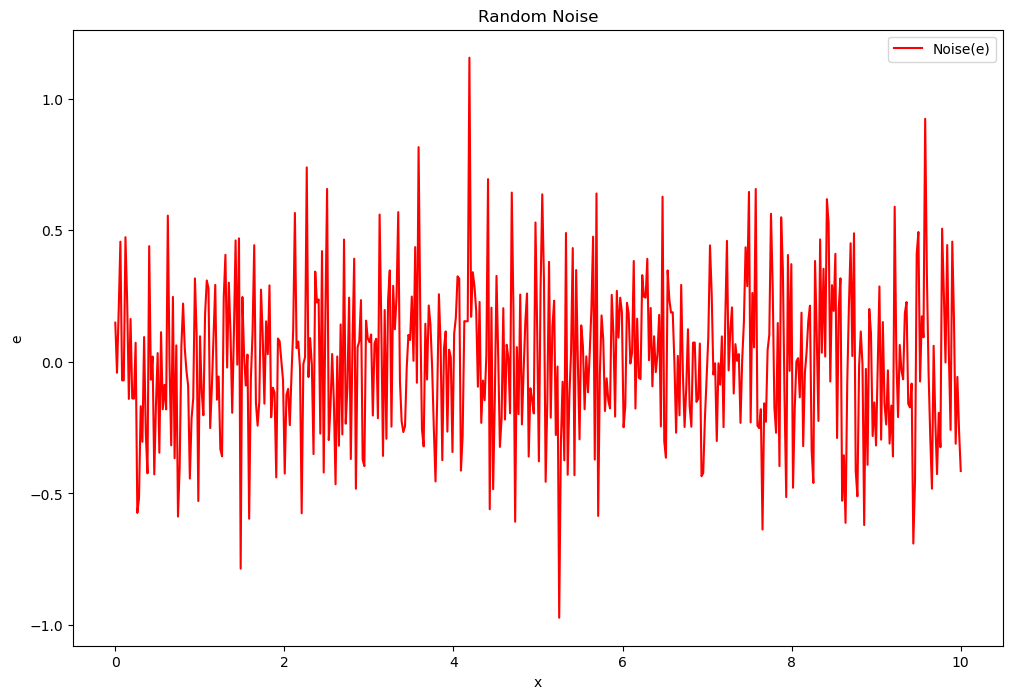

In [3]:
plt.figure(figsize=(12, 8))
plt.plot(x, e, color='r', label='Noise(e)')
plt.title('Random Noise')
plt.xlabel('x')
plt.ylabel('e')
plt.legend()
plt.show()


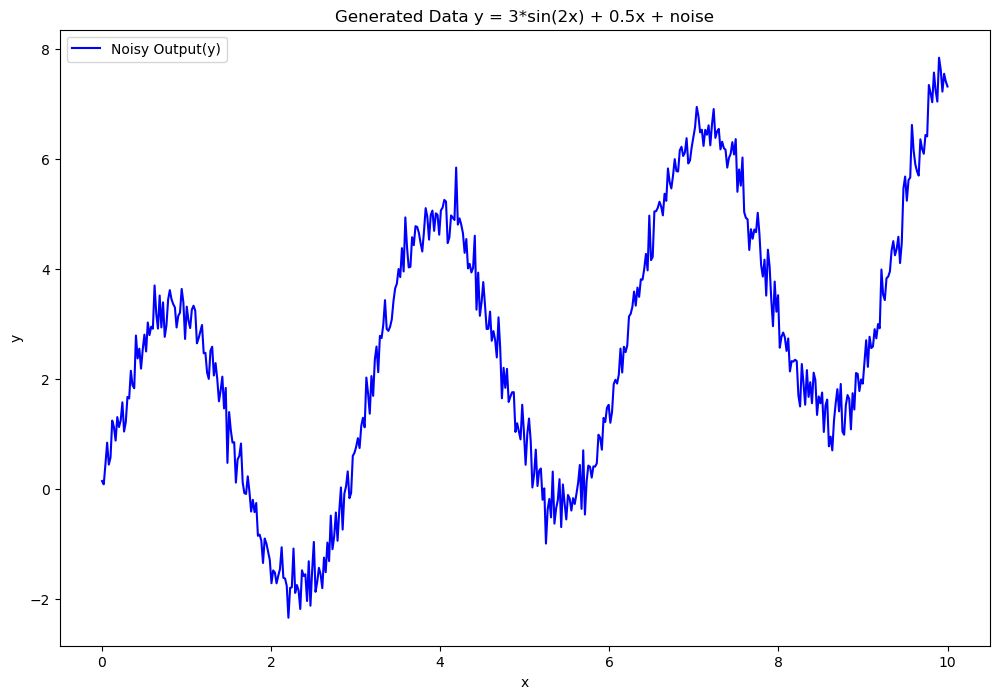

In [4]:
plt.figure(figsize=(12, 8))
plt.plot(x, y, color='b', label='Noisy Output(y)')
plt.title('Generated Data y = 3*sin(2x) + 0.5x + noise')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()



Reshapes the array x from a one-dimensional vector of shape (500,) to a two-dimensional array with shape (500, 1).

In [5]:
x = x.reshape(-1, 1)

In [6]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

This line creates a 10Fold cross-validator object from sklearn.model_selection with the following settings:

- **n_splits=10:** divides the data into 10 folds (for 10-fold cross validation).

- **shuffle=True:** shuffles the data before splitting to ensure randomness.

- **random_state=42:** fixes the random seed to make the splits reproducible.



# 📚 Gradient of Linear Regression Cost Function

## ✍️ Cost function

We want to minimize:

$$
J(w) = \frac{1}{2n} \sum_{i=1}^n (\hat{y}_i - y_i)^2
= \frac{1}{2n} \| X w - y \|^2
$$

where:
- $X$ is the data matrix of shape $(n, m)$
- $w$ is the weight vector of shape $(m, 1)$
- $y$ is the target vector of shape $(n, 1)$

---

## 🔍 Expand cost function

$$
J(w) 
= \frac{1}{2n} (X w - y)^T (X w - y)
$$

Expanding the quadratic form:

$$
= \frac{1}{2n} \left( (X w)^T (X w) - 2 y^T (X w) + y^T y \right)
= \frac{1}{2n} \left( w^T X^T X w - 2 y^T X w + y^T y \right)
$$

---

## 🚀 Compute the gradient w.r.t. $w$

Use these standard matrix derivatives:

- $\frac{\partial}{\partial w} (w^T A w) = 2 A w$ (if $A$ is symmetric)
- $\frac{\partial}{\partial w} (b^T w) = b$

So we have:

$$
\nabla_w J(w) 
= \frac{1}{2n} \left( 2 X^T X w - 2 X^T y \right)
= \frac{1}{n} (X^T X w - X^T y)
$$

---

## ✨ Simplify expression

We can factor out $X^T$:

$$
\nabla_w J(w)
= \frac{1}{n} X^T (X w - y)
$$

---

## ✅ Final result

$$
\boxed{\nabla_w J(w) 
= \frac{1}{n} X^T (X w - y)}
$$

This gradient can then be used in gradient descent updates:

$$
w := w - \eta \nabla_w J(w)
$$


In [7]:
degrees = list(range(1, 26))
means = []
variances = []

for degree in degrees:
    mse_degree = []

    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        poly = PolynomialFeatures(degree=degree, include_bias=False)
        x_train = poly.fit_transform(x_train)
        x_test = poly.transform(x_test)

        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

        x_train = np.c_[x_train, np.ones(x_train.shape[0])]
        x_test = np.c_[x_test, np.ones(x_test.shape[0])]

        model = LinearRegression()
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)
        mse = mean_squared_error(y_test, y_pred)
        mse_degree.append(mse)

    means.append(np.mean(mse_degree))
    variances.append(np.var(mse_degree))
        

In [8]:
print(f"The variance is: {variances}")

The variance is: [0.0566426598153434, 0.0630855539751686, 0.06279048467094074, 0.03899165497293485, 0.09346321884227812, 0.07859346142192716, 0.09302084300114119, 0.1355038337536289, 0.004949543752737971, 0.004330310110223527, 0.0003855979164362495, 0.00030924876375901407, 0.0003374781217190692, 0.0002821507622667288, 0.0002516104610509542, 0.00024872796005880233, 0.0002672527480838083, 0.0002685011239892072, 0.00026585836402910265, 0.0002695936309077559, 0.00028273243582304974, 0.00027938698539594633, 0.00027592685959466695, 0.0002900790778303016, 0.0002717347448947476]


/tmp/ipykernel_26691/1625123406.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend()
/tmp/ipykernel_26691/1625123406.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend()


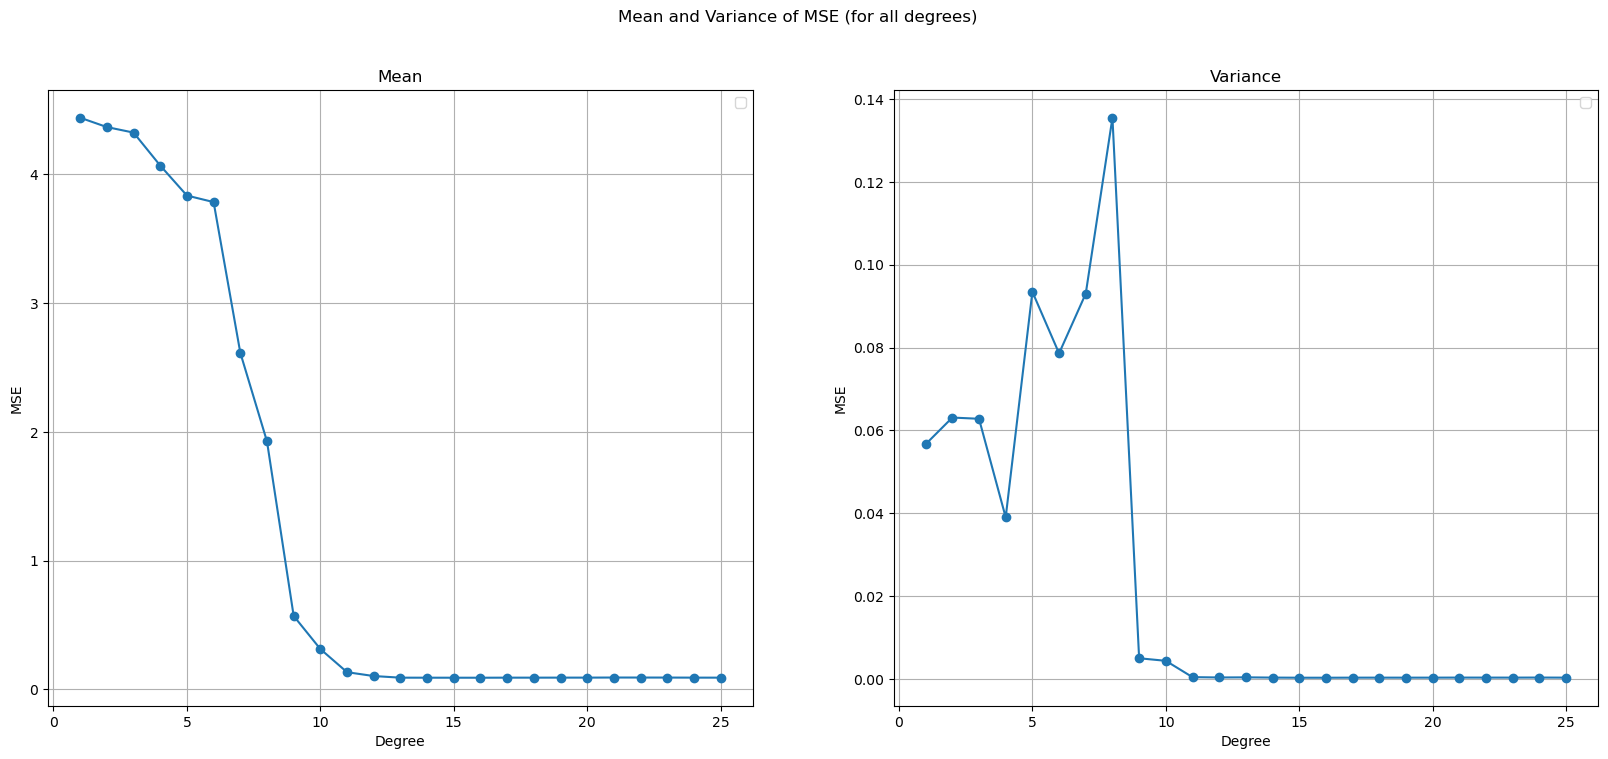

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

ax[0].plot(degrees, means, marker="o")
ax[1].plot(degrees, variances, marker="o")
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("MSE")
ax[1].set_xlabel("Degree")
ax[1].set_ylabel("MSE")
ax[0].legend()
ax[0].set_title('Mean')
ax[1].set_title('Variance')
ax[1].legend()
ax[0].grid()
ax[1].grid()
plt.suptitle("Mean and Variance of MSE (for all degrees)")
plt.show()

/tmp/ipykernel_26691/75514848.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend()
/tmp/ipykernel_26691/75514848.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend()


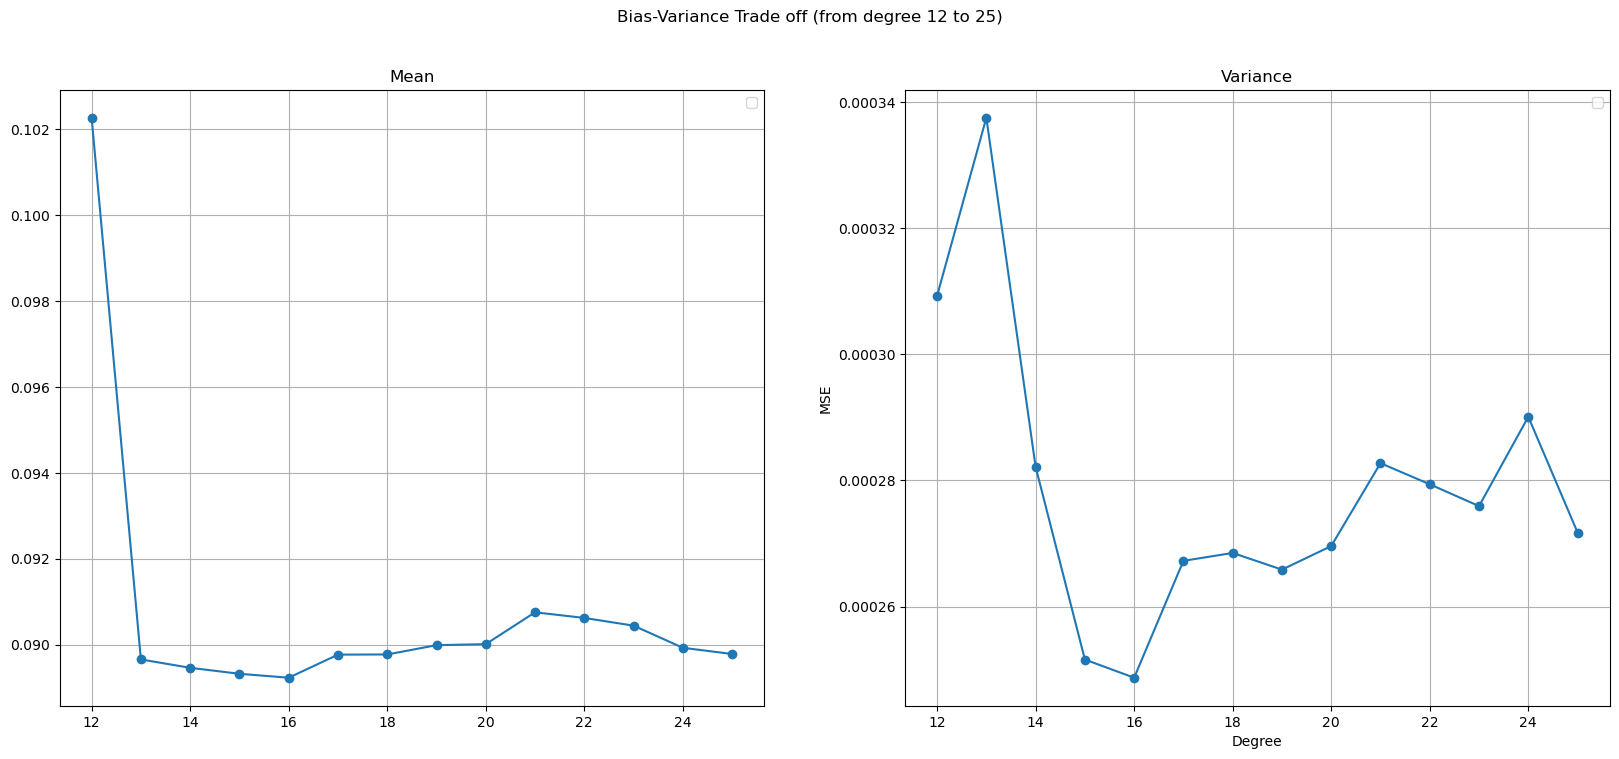

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

ax[0].plot(degrees[11:], means[11:], marker="o")
ax[1].plot(degrees[11:], variances[11:], marker="o")
ax[1].set_xlabel("Degree")
ax[1].set_ylabel("MSE")
ax[0].set_title('Mean')
ax[1].set_title('Variance')
ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()
plt.suptitle("Bias-Variance Trade off (from degree 12 to 25)")
plt.show()

In [11]:
best_mean_degree = degrees[np.argmin(means)]
worst_mean_degree = degrees[np.argmax(vars)]

best_var_degree = degrees[np.argmin(variances)]
worst_var_degree = degrees[np.argmax(variances)]

print(f"Best degree by mean MSE: degree = {best_mean_degree} with mean MSE = {means[np.argmin(means)]:.4f}")
print(f"Worst degree by mean MSE: degree = {worst_mean_degree} with mean MSE = {means[np.argmax(means)]:.4f}")

print(f"Best degree by variance: degree = {best_var_degree} with variance = {variances[np.argmin(variances)]:.4f}")
print(f"Worst degree by variance: degree = {worst_var_degree} with variance = {variances[np.argmax(variances)]:.4f}")


Best degree by mean MSE: degree = 16 with mean MSE = 0.0892
Worst degree by mean MSE: degree = 1 with mean MSE = 4.4403
Best degree by variance: degree = 16 with variance = 0.0002
Worst degree by variance: degree = 8 with variance = 0.1355


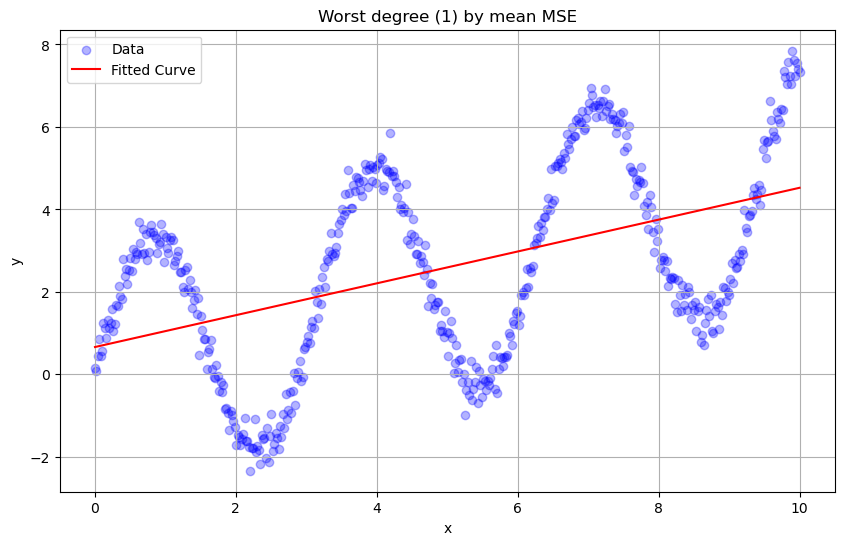

In [24]:
plot_fit(X=x, y=y, degree=1, title=f'Worst degree ({worst_mean_degree}) by mean MSE')

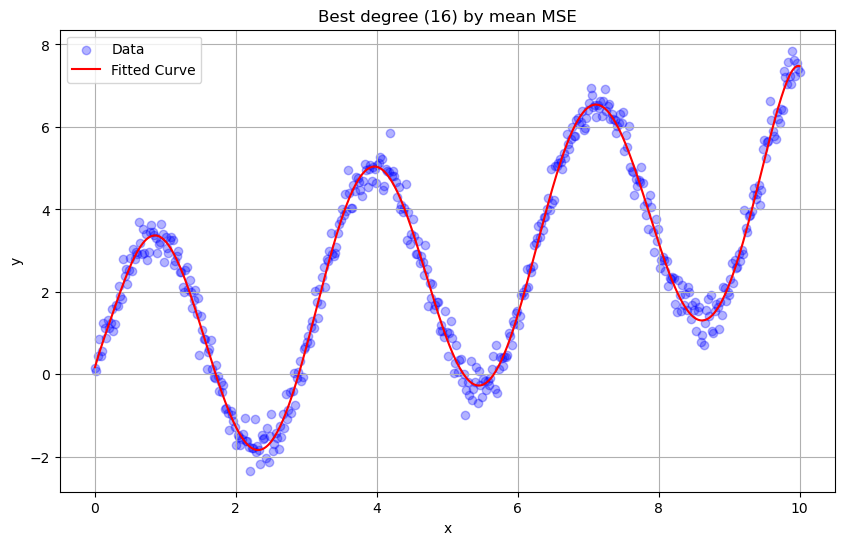

In [25]:
plot_fit(X=x, y=y, degree=16, title=f'Best degree ({best_mean_degree}) by mean MSE')

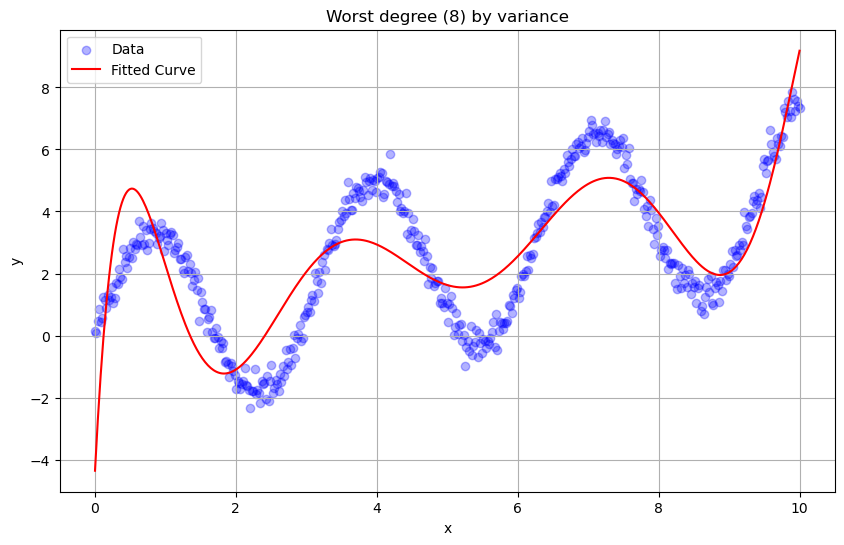

In [27]:
plot_fit(X=x, y=y, degree=8, title=f'Worst degree ({worst_var_degree}) by variance')